In [45]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ft2font
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import itertools
from itertools import zip_longest
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse import dok_matrix
from scipy.sparse import block_diag
from scipy.sparse.linalg import eigsh
import scipy.linalg as la
import os

### Lattice definition

In [30]:
Lx, Ly = 4,4 # lattice dim
L=Lx*Ly
dim=2**(Lx*Ly)

#coordinates of lattice points
coor = []                     
for i in range(Lx):       
    for j in range(Ly):   
        coor.append((i,j))
print(coor)

#lattice
x = [point[0] for point in coor]
y = [point[1] for point in coor]

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


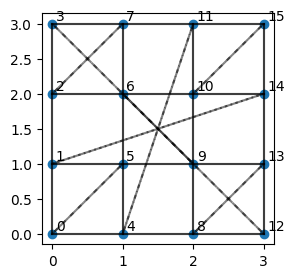

0 --> Nearest neighbors: [4, 3]  -- Next neighbor: [5]
1 --> Nearest neighbors: [5, 0]  -- Next neighbor: [14]
2 --> Nearest neighbors: [6, 1]  -- Next neighbor: [7]
3 --> Nearest neighbors: [7, 2]  -- Next neighbor: [12]
4 --> Nearest neighbors: [8, 7]  -- Next neighbor: [11]
5 --> Nearest neighbors: [9, 4]  -- Next neighbor: [0]
6 --> Nearest neighbors: [10, 5]  -- Next neighbor: [9]
7 --> Nearest neighbors: [11, 6]  -- Next neighbor: [2]
8 --> Nearest neighbors: [12, 11]  -- Next neighbor: [13]
9 --> Nearest neighbors: [13, 8]  -- Next neighbor: [6]
10 --> Nearest neighbors: [14, 9]  -- Next neighbor: [15]
11 --> Nearest neighbors: [15, 10]  -- Next neighbor: [4]
12 --> Nearest neighbors: [0, 15]  -- Next neighbor: [3]
13 --> Nearest neighbors: [1, 12]  -- Next neighbor: [8]
14 --> Nearest neighbors: [2, 13]  -- Next neighbor: [1]
15 --> Nearest neighbors: [3, 14]  -- Next neighbor: [10]


In [31]:
# NEAREST NEIGHBORS
neighbors = []
for idx, (i, j) in enumerate(coor):
    neighbor_list = []
    
    right = (i+1)%Lx  # if i==Lx-1 nn==0 
    neighbor_list.append((right, j))  
    
    top = (j-1)%Ly  # if j==0, nn==Ly-1 (==3)
    neighbor_list.append((i, top))  
    
    neighbors.append(neighbor_list)
    
#---------------------------------------------------
neighbors_indices = []
for neighbor_list in neighbors:
    indices = [coor.index(v) for v in neighbor_list]  # find the index of each nn
    neighbors_indices.append(indices) 
#-------------------------------------------------------

"""
plt.figure(figsize=(3,3))
plt.scatter(x, y)
for idx, point in enumerate(coor):
    plt.text(point[0] + 0.05, point[1] + 0.05, f"{idx}", fontsize=10)

for i, neighbor_list in enumerate(neighbors_indices):
    for neighbor_idx in neighbor_list:
        x_vals = [coor[i][0], coor[neighbor_idx][0]]
        y_vals = [coor[i][1], coor[neighbor_idx][1]]
        plt.plot(x_vals, y_vals, 'k-', alpha=0.5)  # nn line
plt.show()
"""

# NEXT NEIGHBORS - DIAGONALS
avoid = []
diagonals = [None]*Lx*Ly
for idx, (i, j) in enumerate(coor):   
    if i%2==0 and j%2==0:
        next_x = (i+1)  
        next_y = (j+1)
        diagonals[idx]=((next_x, next_y))
        avoid.append((i,j))
        
    if i%2!=0 and j%2!=0:     
        next_x = (i-1)  
        next_y = (j-1)
        diagonals[idx]=((next_x, next_y))
        avoid.append((i,j))  

for idx, (i, j) in enumerate(coor):  
    if (i,j) in avoid:
        continue
    elif i%2==0:
        next_x = (i-1)%Lx 
        next_y = (j+1)%Ly 
        #print(i,j, "-->",next_x, next_y )
        diagonals[idx]=((next_x,next_y))
    elif i%2!=0:
        next_x = (i+1)%Lx 
        next_y = (j-1)%Ly 
        #print(i,j, "-->",next_x, next_y )
        diagonals[idx]=((next_x,next_y))
#print("coor dei secondi vicini",diagonals)

#---------------------------------------------
diag_indices = []
for diag_point in diagonals:
    if diag_point is not None:  #
        index = coor.index(diag_point)  # Trova l'indice della tupla in coor
        diag_indices.append([index])  # Crea una lista con l'indice trovato
    else:
        diag_indices.append([])  
#print("Indici dei secondi vicini diagonali:", diag_indices)

#-----------------------------------------------

# next neighbor lattice
plt.figure(figsize=(3,3))
plt.scatter(x, y)
for idx, point in enumerate(coor):
    plt.text(point[0] + 0.05, point[1] + 0.05, f"{idx}", fontsize=10)

for i, diag_list in enumerate(diag_indices):
    for diag_idx in diag_list:
        x_vals = [coor[i][0], coor[diag_idx][0]]
        y_vals = [coor[i][1], coor[diag_idx][1]]
        plt.plot(x_vals, y_vals, 'k--', alpha=0.5)  # nn line
        
for i, neighbor_list in enumerate(neighbors_indices):
    for neighbor_idx in neighbor_list:
        x_vals = [coor[i][0], coor[neighbor_idx][0]]
        y_vals = [coor[i][1], coor[neighbor_idx][1]]
        plt.plot(x_vals, y_vals, 'k-', alpha=0.5)  # nn line
plt.show()

#check
for idx, (i,j) in enumerate(coor):
    print(f"{idx} --> Nearest neighbors: {neighbors_indices[idx]}", f" -- Next neighbor: {diag_indices[idx]}")

### Hamiltonian definition

In [41]:

# HAMILTONIAN
def flip(state,i,j): #flippa lo spin degli indici i e j
    return state ^ (2**i + 2**j) # ^==xor

def Hamiltonian(J1, J2, state, Lx, Ly):
    result = []
    seen_states_1 = set()  # Per evitare duplicati
    seen_states_2 = set() 
    seen_states_d = set() 
    
    coeff_nn = 0
    coeff_nnn = 0
    coeff_field = 0
    for i in range(Lx*Ly):
        n = (state & 2**i)/2**i #extract bit at position i --> 0 or 1 --> poi (2n-1)/2 per avere -1/2, +1/2
        
        nn_x = neighbors_indices[i][0] #nn dx
        nn_y = neighbors_indices[i][1] #nn up
        nn_d = diag_indices[i][0] #nnn

        nn_1 = (state & 2**nn_x)/2**nn_x
        nn_2 = (state & 2**nn_y)/2**nn_y
        coeff_nn += (2*n-1)*(2*nn_1-1)/4 + (2*n-1)*(2*nn_2-1)/4 # sarebbe (2*n-1)/2 * (2*nn-1)/2 
        if n!=nn_1 : 
            new_state_1 = flip(state,i,nn_x)
            if new_state_1 not in seen_states_1:
                result.append([J1/2,new_state_1])
                seen_states_1.add(new_state_1)
        if n!=nn_2 : 
            new_state_2 = flip(state,i,nn_y)
            #if new_state_2 not in seen_states_2:
            result.append([J1/2,new_state_2])
             #   seen_states_2.add(new_state_2)
        
        nnn = (state & 2**nn_d)/2**nn_d
        coeff_nnn += (2*n-1)*(2*nnn-1)/8 #1/2 in più perchè i vicini in diagonale li sto contando due volte
        if n!=nnn : 
            new_state_d = flip(state,i,nn_d)
            if new_state_d not in seen_states_d:
                result.append([J2/2,new_state_d])
                seen_states_d.add(new_state_d)
          
    result.append([J1*coeff_nn+J2*coeff_nnn, state])
    return result 


#MATRICE DIAGONALE A BLOCCHI
def build_basisN(L,N): #L=Lx*Ly number of sites, N number of spin up in the sector
    basisN = []
    for n in range(2**L):
        particle_count = bin(n).count('1') #count the 1 in n
        if particle_count == N:
            basisN.append(n) #check if n belongs to the N sector
    return basisN


def build_HN(L,N,J1,J2):
    basisN = build_basisN(L,N)
    dimN = len(basisN) #dimension of the subspace S_N
    HN = dok_matrix((dimN,dimN)) #crea matrice vuota sparsa

    for b,n in enumerate(basisN): #b index, n binary state
        output = Hamiltonian(J1,J2,n,Lx,Ly) #H|n>
        for coeff,m in output:
            try:
                a = basisN.index(m)
                HN[a,b]+=coeff
            except ValueError:
                continue
    return HN.tocsr() #csr


def H_diag_block(L,J1,J2):
    blocks = []
    for N in range(L+1):
        basisN = build_basisN(L,N)
        if len(basisN) > 0:
            HN = build_HN(L,N,J1,J2)
            blocks.append(HN)
    H = block_diag(blocks, format="csr")
    return H


### Chancing J1 J2

In [42]:
save_path = "/home/costanza/UNIVERSITÀ/secondo semestre/MOLTI CORPI/dati/"

In [43]:
angles = [i*np.pi/8 for i in range(5)]
theta = angles[1:-1]

In [47]:
%%time
for i in range(len(theta)):
    print("-------------------------------")
    print(i, f"theta={theta[i]}")
    J1=np.sin(theta[i])
    J2=np.cos(theta[i])
    
    folder_name = f"J1={round(J1,2)}_J2={round(J2,2)}/"
    full_path = save_path + folder_name
    os.makedirs(full_path, exist_ok=True)

    HN = []
    for N in range(Lx*Ly+1):
        HN.append(build_HN(L,N,J1,J2))
        print(HN[N].shape)

        HN_dict = {}
        HN_dict[f'HN_{N}'] = HN[N].toarray()

        eigvals, eigvecs = la.eigh(HN_dict[f'HN_{N}'])
        print(f"finito di diagonalizzare HN_{N} alle", datetime.now())
        print("")
        
        folder_eig = f"eigvals block N={N}/"
        path = full_path + folder_eig
        os.makedirs(path, exist_ok=True)
        np.save(path+f"eigvals_N={N}", eigvals)
        np.save(path+f"eigvecs_N={N}", eigvecs)

-------------------------------
0 theta=0.39269908169872414
(1, 1)
finito di diagonalizzare HN_0 alle 2025-03-17 22:28:10.994243

(16, 16)
finito di diagonalizzare HN_1 alle 2025-03-17 22:28:11.064221

(120, 120)
finito di diagonalizzare HN_2 alle 2025-03-17 22:28:11.330697

(560, 560)
finito di diagonalizzare HN_3 alle 2025-03-17 22:28:12.864432

(1820, 1820)
finito di diagonalizzare HN_4 alle 2025-03-17 22:28:25.147048

(4368, 4368)
finito di diagonalizzare HN_5 alle 2025-03-17 22:29:42.739930

(8008, 8008)
finito di diagonalizzare HN_6 alle 2025-03-17 22:36:27.781426

(11440, 11440)
finito di diagonalizzare HN_7 alle 2025-03-17 23:01:56.709603

(12870, 12870)
finito di diagonalizzare HN_8 alle 2025-03-17 23:24:32.665211

(11440, 11440)
finito di diagonalizzare HN_9 alle 2025-03-17 23:50:08.137671

(8008, 8008)
finito di diagonalizzare HN_10 alle 2025-03-17 23:56:37.537986

(4368, 4368)
finito di diagonalizzare HN_11 alle 2025-03-17 23:57:52.431855

(1820, 1820)
finito di diagonalizz